# Assignment 4 - Metrics (IoU, NMS)

Welcome to your 4th assignment. You will learn about merging overlapping bounding boxes outputed by an object detection system such as YOLO. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242 ). 

Run the following cell to load the packages and dependencies that are going to be useful for your journey!

In [1]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from drawing_utils import read_classes, draw_boxes, scale_boxes

%matplotlib inline

In [2]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """ Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        box_confidence -- np.array of shape (19, 19, 5, 1)
        boxes -- np.array of shape (19, 19, 5, 4)
        box_class_probs -- np.array of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
            then get rid of the corresponding box
    
    Returns:
        scores -- np.array of shape (None,), containing the class probability score for selected boxes
        boxes -- np.array of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- np.array of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes= np.argmax(scores, axis=-1)
    max_box_scores = np.amax(scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    mask = max_box_scores >= threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = max_box_scores[mask]
    boxes = boxes[mask]
    classes = box_classes[mask]
    
    return scores, boxes, classes

In [3]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
box_confidence = np.random.normal(size=(19, 19, 5, 1), loc=1, scale=4)
boxes = np.random.normal(size=(19, 19, 5, 4), loc=1, scale=4)
box_class_probs = np.random.normal(size=(19, 19, 5, 80), loc=1, scale=4)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 54.01492488333001
boxes[2] = [-1.92142838 -2.04944615 -4.78776134 11.48229538]
classes[2] = 8
scores.shape = (1790,)
boxes.shape = (1790, 4)
classes.shape = (1790,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 54.0149     |
| **boxes[2]**      | [-1.92142838 -2.04944615 -4.78776134 11.48229538] |
| **classes[2]**    | 8           |
| **scores.shape**  | (1790,)        |
| **boxes.shape**   | (1790, 4)      |
| **classes.shape** | (1790,)       |

### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <b> Figure 7 </b>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <b> Figure 8 </b>: Definition of "Intersection over Union". <br> </center></caption>



In [4]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    x_1 = max(box1[0], box2[0])
    y_1 = max(box1[1], box2[1])
    x_2 = min(box1[2], box2[2])
    y_2 = min(box1[3], box2[3])

    # Calculate area of intersectional rectangle, and the prediction and ground truth boxes
    area_intersection = max(0, x_2 - x_1) * max(0, y_2 - y_1)
    area_pred = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_gt = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Divide area of intersection by intersection of union
    iou = area_intersection / float(area_pred + area_gt - area_intersection)

    return iou

In [5]:
#DO NOT EDIT THIS CODE
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


**Expected Output**:

| Variable          | Value               |
| ----------------- | ------------------- |
| **iou**           | 0.14285714285714285 |


You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: Implement yolo_non_max_suppression() using your iou function.
- Hint: use [index arrays](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.indexing.html#index-arrays)

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
        scores -- np.array of shape (None,), output of yolo_filter_boxes()
        boxes -- np.array of shape (None, 4), output of yolo_filter_boxes() 
            that have been scaled to the image size (see later)
        classes -- np.array of shape (None,), output of yolo_filter_boxes()
        max_boxes -- integer, maximum number of predicted boxes you'd like
        iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. 
    Note also that this function will transpose the shapes of scores, boxes, classes. 
    This is made for convenience.
    """
        
    nms_indices = []
    idx_checked = []

    idx_sorted = np.argsort(-scores)
    sorted_scores = scores[idx_sorted]
    sorted_boxes = boxes[idx_sorted]
    sorted_classes = classes[idx_sorted]

    for i, box1 in enumerate(sorted_boxes):
        if len(nms_indices) == max_boxes:
            break
        
        if i not in idx_checked:
            nms_indices.append(i)
            for j, box2 in enumerate(sorted_boxes):
                if iou(box1, box2) >= iou_threshold and j >= i:
                    idx_checked.append(j)
    
    scores = sorted_scores[nms_indices]
    boxes = sorted_boxes[nms_indices]
    classes = sorted_classes[nms_indices]

    
    return scores, boxes, classes

In [7]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
scores = np.random.normal(size=(54,), loc=1, scale=4)
boxes = np.random.normal(size=(54,4), loc=1, scale=4)
classes = np.random.normal(size=(54,), loc=1, scale=4)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 8.803101580927159
boxes[2] = [ 1.62602615  1.92872414 -1.38926428  0.04831308]
classes[2] = -1.9227110114592993
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 8.8031      |
| **boxes[2]**      | [ 1.62602615  1.92872414 -1.38926428  0.04831308] |
| **classes[2]**    | -1.9227     |
| **scores.shape**  | (10,)       |
| **boxes.shape**   | (10, 4)     |
| **classes.shape** | (10,)       |

### 2.4 Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. YOLO works with shrinked down bounding boxes and you can scale them back using the following functions (which we have provided): 
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

In [8]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
        yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 np.array:
                        box_confidence: tensor of shape (None, 19, 19, 5, 1)
                        boxes: tensor of shape (None, 19, 19, 5, 4)
                        box_class_probs: tensor of shape (None, 19, 19, 5, 80)
        image_shape -- np.array of shape (2,) containing the input shape, in this notebook we use 
            (608., 608.) (has to be float32 dtype)
        max_boxes -- integer, maximum number of predicted boxes you'd like
        score_threshold -- real value, if [ highest class probability score < threshold], 
            then get rid of the corresponding box
        iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
        scores -- np.array of shape (None, ), predicted score for each box
        boxes -- np.array of shape (None, 4), predicted box coordinates
        classes -- np.array of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, boxes, box_class_probs = yolo_outputs
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [9]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
yolo_outputs = (np.random.normal(size=(19, 19, 5, 1,), loc=1, scale=4),
                np.random.normal(size=(19, 19, 5, 4,), loc=1, scale=4),
                np.random.normal(size=(19, 19, 5, 80,), loc=1, scale=4))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 143.33886713132935
boxes[2] = [ 1366.07098516  7609.25352373  1133.27145691 -9957.2042546 ]
classes[2] = 79
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 143.33886713132935     |
| **boxes[2]**      | [ 1366.07098516  7609.25352373  1133.27145691 -9957.2042546 ] |
| **classes[2]**    | 79          |
| **scores.shape**  | (10,)       |
| **boxes.shape**   | (10, 4)     |
| **classes.shape** | (10,)       |


**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

## 3 - Test on YOLO output

In this part, you are going to run your thresholding and non-maximum-suppression algorithms on the output of a YOLO forward-pass already computed for your convenience.

In [10]:
# DO NOT CHANGE
image = Image.open("test.jpg")
box_confidence = np.load("box_confidence.npy")
boxes = np.load("boxes.npy")
box_class_probs = np.load("box_class_probs.npy")
yolo_outputs = (box_confidence, boxes, box_class_probs)

### 3.1 - Defining classes and image shape.

Recall that we are trying to detect 80 classes. We have gathered the information about the 80 classes in "coco_classes.txt". Let's load these quantities into the model by running the next cell. 

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [11]:
# DO NOT CHANGE
image_shape = (720., 1280.)

### 3.2 - Filtering boxes

`yolo_outputs` gives you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this. 

In [12]:
#DO NOT EDIT THIS CODE
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, image_shape)

### 3.3 - Show the output of your algorithm

Run the following cell to verify that your code is correct.

Found 7 boxes
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


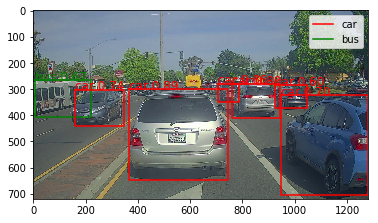

In [13]:
#DO NOT EDIT THIS CODE
# Print predictions info
print('Found {} boxes'.format(len(out_boxes)))
# Draw bounding boxes on the image
draw_boxes(image, out_scores, out_boxes, out_classes)
# Display the results in the notebook
imshow(image)
import matplotlib.pyplot as plt

**Expected Output**:

**Found 7 boxes**

| Object            | Confidence| position| size  |
| ----------------- | ----------|---------|-------- |
| **car**           | 0.60| (925, 285) |(1045, 374) |
| **car**           | 0.66 |(706, 279) |(786, 350)  |
| **bus**           | 0.67| (5, 266)| (220, 407)    |
| **car**           | 0.70 |(947, 324) |(1280, 705) |
| **car**           | 0.74 |(159, 303) |(346, 440)  |
| **car**           | 0.80 |(761, 282) |(942, 412)  |
| **car**           | 0.89 |(367, 300) |(745, 648)  |

**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because running a YOLO model is non-trivial and requires many libraries and files, we used previously executed model results in this exercise. If you wish, you can also try running the YOLO model with your own image.